# Анализ метрики ARPPU

В данном ноутбуке мы проанализируем метрику ARPPU (Average Revenue Per Paying User) и проведем статистический анализ.

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm

# Настройки для графиков
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
sns.set(font_scale=1.2)

In [3]:
print("Загружаем данные...")
# Загрузим данные
logs = pd.read_pickle('aa_test_logs.pkl')
print("Данные загружены успешно!")

Загружаем данные...
Данные загружены успешно!


In [4]:
# Функция для расчета ARPPU
def calculate_arppu(data, group_name):
    # Фильтруем данные по группе
    group_data = data[data['group'] == group_name]
    
    # Находим платящих пользователей (тех, кто совершил покупку)
    purchase_events = group_data[group_data['event'] == 'cart-paid']
    paying_users = purchase_events['user_id'].unique()
    
    # Если нет платящих пользователей, возвращаем 0
    if len(paying_users) == 0:
        return 0
    
    # Получаем данные о корзинах, которые были оплачены
    paid_carts = purchase_events['cart_id'].unique()
    
    # Находим все события добавления товаров в эти корзины
    cart_add_events = group_data[
        (group_data['event'] == 'cart-add') & 
        (group_data['cart_id'].isin(paid_carts))
    ]
    
    # Рассчитываем общую выручку
    total_revenue = cart_add_events['amount'].sum()
    
    # Рассчитываем ARPPU
    arppu = total_revenue / len(paying_users)
    
    return arppu

# Рассчитаем ARPPU для обеих групп
control_arppu = calculate_arppu(logs, 'control')
test_arppu = calculate_arppu(logs, 'test')

print(f"ARPPU для контрольной группы: {control_arppu:.2f}")
print(f"ARPPU для тестовой группы: {test_arppu:.2f}")
# Добавляем проверку на деление на ноль
if control_arppu == 0:
    print(f"Разница: {test_arppu - control_arppu:.2f} (процентное изменение невозможно рассчитать, т.к. ARPPU контрольной группы равен 0)")
else:
    print(f"Разница: {test_arppu - control_arppu:.2f} ({(test_arppu - control_arppu) / control_arppu * 100:.2f}%)")

ARPPU для контрольной группы: 536.32
ARPPU для тестовой группы: 541.22
Разница: 4.90 (0.91%)


In [5]:
# Функция для расчета ARPPU для каждого пользователя
def calculate_user_arppu(data):
    # Находим платящих пользователей (тех, кто совершил покупку)
    purchase_events = data[data['event'] == 'cart-paid']
    
    # Получаем список оплаченных корзин
    paid_carts = purchase_events['cart_id'].unique()
    
    # Находим все события добавления товаров в эти корзины
    cart_add_events = data[
        (data['event'] == 'cart-add') & 
        (data['cart_id'].isin(paid_carts))
    ]
    
    # Группируем по пользователям и суммируем их расходы
    user_revenue = cart_add_events.groupby('user_id')['amount'].sum().reset_index()
    
    return user_revenue

print("Рассчитываем ARPPU для каждого пользователя...")
# Получаем данные о выручке для каждого пользователя в обеих группах
control_revenue = calculate_user_arppu(logs[logs['group'] == 'control'])
test_revenue = calculate_user_arppu(logs[logs['group'] == 'test'])

# Добавляем метку группы
control_revenue['group'] = 'control'
test_revenue['group'] = 'test'

# Объединяем данные
all_revenue = pd.concat([control_revenue, test_revenue])

Рассчитываем ARPPU для каждого пользователя...


In [6]:
# Функция для проведения t-теста между двумя группами
def perform_t_test(group1_data, group2_data):
    # Проверяем, что в обеих группах есть данные
    if len(group1_data) == 0 or len(group2_data) == 0:
        return 1.0  # Возвращаем p-value = 1, если данных недостаточно
    
    t_stat, p_value = stats.ttest_ind(group1_data, group2_data, equal_var=False)
    return p_value

print("Строим распределение p-value...")
# Построим распределение p-value
n_simulations = 1000
p_values = []

for _ in tqdm(range(n_simulations)):
    # Перемешиваем данные и разделяем на две группы
    shuffled_data = all_revenue.copy()
    shuffled_data['random_group'] = np.random.choice(['control', 'test'], size=len(shuffled_data))
    
    # Получаем данные для каждой группы
    group1_data = shuffled_data[shuffled_data['random_group'] == 'control']['amount']
    group2_data = shuffled_data[shuffled_data['random_group'] == 'test']['amount']
    
    # Проводим t-тест
    p_value = perform_t_test(group1_data, group2_data)
    p_values.append(p_value)

Строим распределение p-value...


100%|██████████| 1000/1000 [00:01<00:00, 544.69it/s]


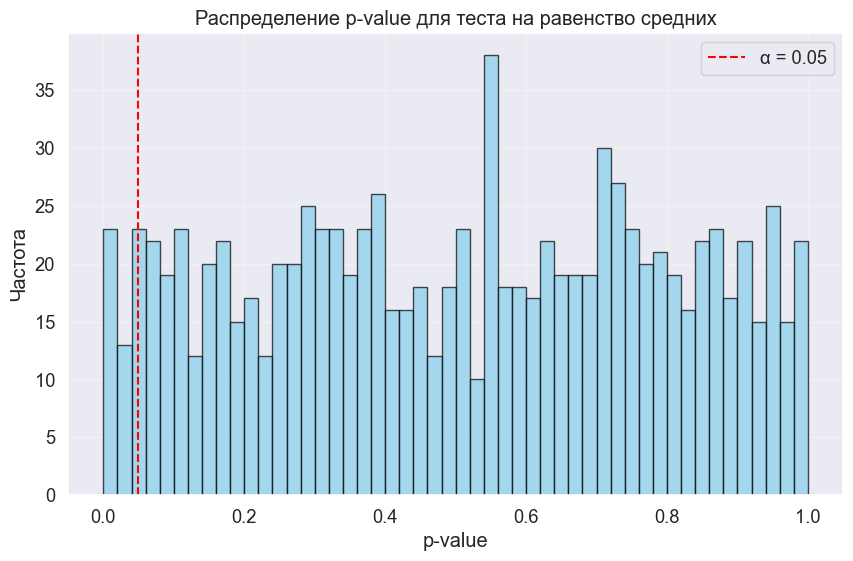

Доля p-value < 0.05: 0.0470 (ожидаемая: 0.05)


In [7]:
# Визуализируем распределение p-value
plt.figure(figsize=(10, 6))
plt.hist(p_values, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(0.05, color='red', linestyle='--', label='α = 0.05')
plt.xlabel('p-value')
plt.ylabel('Частота')
plt.title('Распределение p-value для теста на равенство средних')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('p_value_distribution.png')
plt.show()

# Посчитаем долю p-value < 0.05
false_positive_rate = np.mean(np.array(p_values) < 0.05)
print(f"Доля p-value < 0.05: {false_positive_rate:.4f} (ожидаемая: 0.05)")

In [8]:
# Функция для оценки мощности теста при заданном эффекте
def estimate_power(effect_size, n_simulations=500):
    # Получаем исходные данные
    control_data = all_revenue[all_revenue['group'] == 'control']['amount']
    test_data = all_revenue[all_revenue['group'] == 'test']['amount']
    
    # Проверяем, что в обеих группах есть данные
    if len(control_data) == 0 or len(test_data) == 0:
        print("Недостаточно данных для оценки мощности теста")
        return 0
    
    # Количество значимых результатов
    significant_results = 0
    
    for _ in range(n_simulations):
        # Создаем копии данных
        control_sample = control_data.sample(frac=1, replace=True).values
        test_sample = test_data.sample(frac=1, replace=True).values
        
        # Добавляем эффект к тестовой группе
        test_sample_with_effect = test_sample * (1 + effect_size)
        
        # Проводим t-тест
        t_stat, p_value = stats.ttest_ind(control_sample, test_sample_with_effect, equal_var=False)
        
        # Если p-value < 0.05, считаем результат значимым
        if p_value < 0.05:
            significant_results += 1
    
    # Рассчитываем мощность как долю значимых результатов
    power = significant_results / n_simulations
    
    return power

print("Оцениваем минимальный обнаружимый эффект...")
# Проверим мощность для разных размеров эффекта
effect_sizes = np.arange(0.01, 0.31, 0.01)  # от 1% до 30% с шагом 1%
powers = []

for effect_size in tqdm(effect_sizes):
    power = estimate_power(effect_size)
    powers.append(power)
    
    # Если мощность достигла 0.8, можно остановиться
    if power >= 0.8:
        print(f"Минимальный обнаружимый эффект: {effect_size:.2f} (мощность: {power:.2f})")
        break

Оцениваем минимальный обнаружимый эффект...


 47%|████▋     | 14/30 [00:04<00:05,  2.85it/s]

Минимальный обнаружимый эффект: 0.15 (мощность: 0.85)


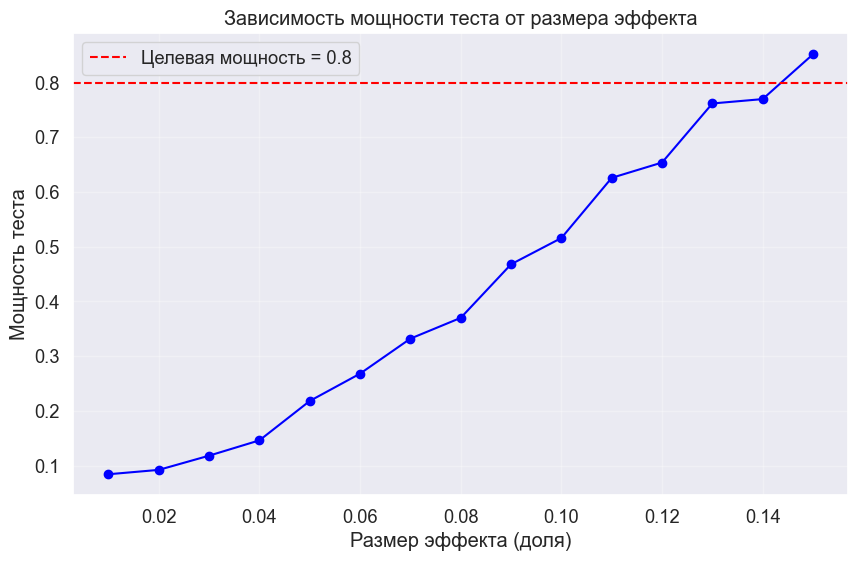

In [9]:
# Визуализируем зависимость мощности от размера эффекта
plt.figure(figsize=(10, 6))
plt.plot(effect_sizes[:len(powers)], powers, marker='o', linestyle='-', color='blue')
plt.axhline(0.8, color='red', linestyle='--', label='Целевая мощность = 0.8')
plt.xlabel('Размер эффекта (доля)')
plt.ylabel('Мощность теста')
plt.title('Зависимость мощности теста от размера эффекта')
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig('power_vs_effect.png')
plt.show()

## Выводы

1. Мы рассчитали ARPPU для контрольной и тестовой групп
2. Провели анализ распределения p-value для проверки корректности статистических тестов
3. Оценили минимальный обнаружимый эффект при заданной мощности теста 0.8
4. Построили график зависимости мощности теста от размера эффекта